# Weather Trends Data Analysis

## Table of Contents
- <a href='#introduction'>Introduction</a>
- <a href='#wrangling'>Data Wrangling</a>
- <a href='#analysis'>Exploratory Data Analysis</a>
- <a href='#conclusions'>Conclusions</a>
- <a href='#sources'>Sources</a>

<a id='introduction'></a>
## Introduction

In this analysis, I will examine global weather data and compare it to weather data from San Jose, CA (where I currently live) and Portland, OR (where I grew up). All of the data comes from a database on Udacity's website that provides annual average temperatures for select cities around the world. The question that will guide this analysis is: **What are the overall trends of annual average temperatures and how do these trends differ between global data, San Jose, and Portland?**

Before beginning my exploration of weather trends, I had to download the CSV data files using SQL queries. First, I used the following SQL query to narrow down the list of cities to only those located in the US.

```
SELECT *
FROM city_list
WHERE country = 'United States'
```

Based on the output from the above query, I found that the database contains weather data for San Jose and Portland. As a result, I used the following SQL queries to find the weather data for these two cities. I included both the city and country in the `WHERE` clause in case there were other cities named `'San Jose'` or `'Portland'` in the database.

```
SELECT *
FROM city_data
WHERE city = 'San Jose' AND country = 'United States'

SELECT *
FROM city_data
WHERE city = 'Portland' AND country = 'United States'
```

I downloaded the San Jose results as `results_san_jose.csv` and the Portland results as `results_portland.csv`. Finally, I used the following SQL query to extract all of the global weather data.

```
SELECT *
FROM global_data
```

I downloaded the global weather data as `results_global.csv`.

After saving the CSV files, I now have to import the appropriate libraries and read in the data. I will also print the first few rows of each dataframe to see what they look like.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.stats import pearsonr

In [2]:
sj_weather = pd.read_csv('results_san_jose.csv')
sj_weather.head()

,year,city,country,avg_temp
0,1849,San Jose,United States,14.12
1,1850,San Jose,United States,13.80
2,1851,San Jose,United States,14.39
3,1852,San Jose,United States,13.81
4,1853,San Jose,United States,14.40


In [3]:
pdx_weather = pd.read_csv('results_portland.csv')
pdx_weather.head()

,year,city,country,avg_temp
0,1828,Portland,United States,9.38
1,1829,Portland,United States,9.11
2,1830,Portland,United States,NaN
3,1831,Portland,United States,NaN
4,1832,Portland,United States,6.25


In [4]:
global_weather = pd.read_csv('results_global.csv')
global_weather.head()

,year,avg_temp
0,1750,8.72
1,1751,7.98
2,1752,5.78
3,1753,8.39
4,1754,8.47


<a id='wrangling'></a>
## Data Wrangling

### General Properties

Next, I will explore the general properties of each dataframe, specifically the shape, number of duplicated rows, data types, missing values, and descriptive statistics. Since I would like to repeat this with all three dataframes, I will create a function to print all of the required information.

In [5]:
def print_properties(df):
    print('Shape: {}'.format(df.shape))
    print('\n')
    print('Number of duplicated rows: {}'.format(sum(df.duplicated())))
    print('\n')
    print(df.info())
    print('\n')
    print(df.describe())

In [6]:
print_properties(sj_weather)

Shape: (165, 4)


Number of duplicated rows: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      165 non-null    int64  
 1   city      165 non-null    object 
 2   country   165 non-null    object 
 3   avg_temp  165 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB
None


              year    avg_temp
count   165.000000  165.000000
mean   1931.000000   14.450788
std      47.775517    0.504885
min    1849.000000   13.220000
25%    1890.000000   14.120000
50%    1931.000000   14.390000
75%    1972.000000   14.760000
max    2013.000000   16.230000


The `sj_weather` dataframe looks fine, as there are no duplicated rows, incorrect data types, or missing values. The descriptive statistics also look reasonable, with none of the `avg_temp` values being unreasonably high or low. It is also important to note that the earliest year is 1849 and the most recent year is 2013. I will keep track of this in the other dataframes to make sure that similar timeframes are being compared.

In [7]:
print_properties(pdx_weather)

Shape: (186, 4)


Number of duplicated rows: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      186 non-null    int64  
 1   city      186 non-null    object 
 2   country   186 non-null    object 
 3   avg_temp  183 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.9+ KB
None


              year    avg_temp
count   186.000000  183.000000
mean   1920.500000    9.759891
std      53.837719    0.672585
min    1828.000000    6.250000
25%    1874.250000    9.335000
50%    1920.500000    9.740000
75%    1966.750000   10.135000
max    2013.000000   11.740000


There are no duplicated rows or incorrect data types in `pdx_weather`, but there are missing values in the `avg_temp` column. I will print those below to see if there is any particular reason that they are blank. Otherwise, the descriptive statistics here also look reasonable. The earliest year is 1828 and the most recent year is 2013.

In [8]:
pdx_weather[pdx_weather.isna().any(axis=1)]

,year,city,country,avg_temp
2,1830,Portland,United States,NaN
3,1831,Portland,United States,NaN
18,1846,Portland,United States,NaN


The rows above do not look like special cases, so I will use mean imputation to eliminate missing values as part of the data cleaning process.

In [9]:
print_properties(global_weather)

Shape: (266, 2)


Number of duplicated rows: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      266 non-null    int64  
 1   avg_temp  266 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB
None


              year    avg_temp
count   266.000000  266.000000
mean   1882.500000    8.369474
std      76.931788    0.584747
min    1750.000000    5.780000
25%    1816.250000    8.082500
50%    1882.500000    8.375000
75%    1948.750000    8.707500
max    2015.000000    9.830000


There are no duplicated rows, incorrect data types, or missing values in `global_weather`. Additionally, the descriptive statistics look reasonable. The earliest year is 1750 and the most recent year is 2015.

The time period that is common to all three dataframes is 1849-2013. This information will be useful when plotting the trends.

### Data Cleaning

Based on the exploration above, the only data cleaning that I will need to perform is mean imputation on `pdx_weather`. I will find the mean of the `avg_temp` column, and then fill all of the missing values with this mean.

In [10]:
pdx_weather_mean = pdx_weather['avg_temp'].mean()
pdx_weather_mean

9.759890710382514

In [11]:
pdx_weather['avg_temp'].fillna(pdx_weather_mean, inplace=True)

I will check `pdx_weather` to confirm that there are no longer any missing values before moving on.

In [12]:
pdx_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      186 non-null    int64  
 1   city      186 non-null    object 
 2   country   186 non-null    object 
 3   avg_temp  186 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.9+ KB


<a id='analysis'></a>
## Exploratory Data Analysis

### What are the overall trends of annual average temperatures and how do these trends differ between global data, San Jose, and Portland?

Now that the data cleaning is done, I will calculate the moving average for each dataframe. I will use a moving average of 10 years, as this will allow me to see trends over several years without having too much fluctuation.

In [13]:
sj_weather['moving_avg'] = sj_weather['avg_temp'].rolling(window=10).mean()
sj_weather.head()

,year,city,country,avg_temp,moving_avg
0,1849,San Jose,United States,14.12,NaN
1,1850,San Jose,United States,13.80,NaN
2,1851,San Jose,United States,14.39,NaN
3,1852,San Jose,United States,13.81,NaN
4,1853,San Jose,United States,14.40,NaN


The first nine rows in the resulting data will have missing values for `moving_avg`, since 10 prior years are needed to calculate the metric. This means that the first year with a moving average is 1858. Because I do not want to make comparisons for years in which there is no data, I will limit the data only to the time period where there are 10-year moving averages for San Jose, Portland, and global data (1858-2013). Because I know that `sj_weather` ends in 2013, I only need to filter for the beginning year.

In [14]:
sj_weather_new = sj_weather[sj_weather['year'] >= 1858]
sj_weather_new.head()

,year,city,country,avg_temp,moving_avg
9,1858,San Jose,United States,14.19,14.177
10,1859,San Jose,United States,13.71,14.136
11,1860,San Jose,United States,13.81,14.137
12,1861,San Jose,United States,14.88,14.186
13,1862,San Jose,United States,14.43,14.248


I would like to perform the same process with the other two dataframes, so I will create a function that calculates the 10-year moving average and filters the dataframe.

In [15]:
def moving_avg(df):
    df['moving_avg'] = df['avg_temp'].rolling(window=10).mean()
    df_new = df[(df['year'] >= 1858) & (df['year'] <= 2013)]
    return df_new

In [16]:
pdx_weather_new = moving_avg(pdx_weather)
pdx_weather_new.head()

,year,city,country,avg_temp,moving_avg
30,1858,Portland,United States,9.31,9.555
31,1859,Portland,United States,8.66,9.516
32,1860,Portland,United States,9.77,9.561
33,1861,Portland,United States,9.55,9.514
34,1862,Portland,United States,8.73,9.456


In [17]:
global_weather_new = moving_avg(global_weather)
global_weather_new.head()

,year,avg_temp,moving_avg
108,1858,8.10,8.038
109,1859,8.25,8.065
110,1860,7.96,8.071
111,1861,7.85,8.038
112,1862,7.56,7.984


Now I will plot the three new dataframes on the same line graph showing moving average temperatures from 1858 to 2013.

When I created the initial visualization, the default axis range was around 8-15 degrees Celsius, so that the Portland and global data were at the very bottom, and the San Jose data was at the very top. However, I thought that this would be misleading as it would show a drastic difference between San Jose and the rest of the world. In order to display a less drastic difference, I decided to change the y-axis range to `(6, 17)`.

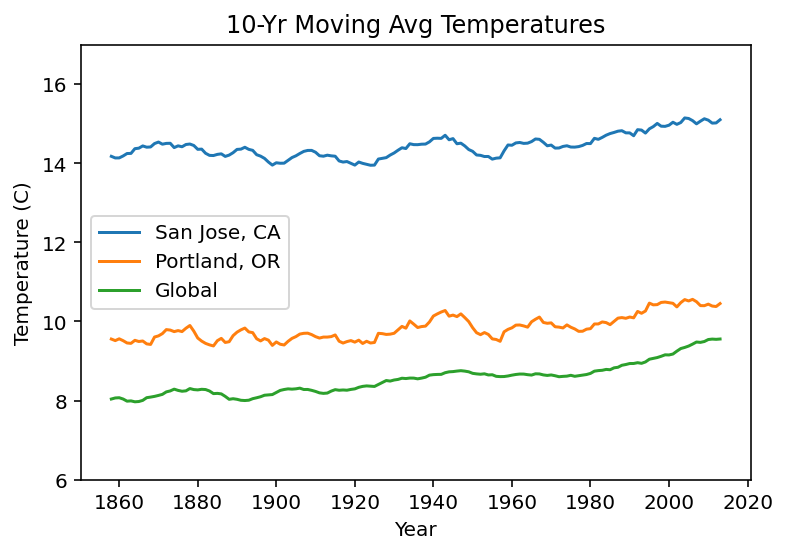

In [18]:
plt.plot(sj_weather_new['year'], sj_weather_new['moving_avg'], label='San Jose, CA')
plt.plot(pdx_weather_new['year'], pdx_weather_new['moving_avg'], label='Portland, OR')
plt.plot(global_weather_new['year'], global_weather_new['moving_avg'], label='Global')
plt.title('10-Yr Moving Avg Temperatures')
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.ylim(6, 17)
plt.legend();

The 10-year moving average temperatures appear to have increased slightly over 1858-2013. San Jose is consistently the warmer than Portland, and both cities are consistently warmer than the global average.

I will also use Pearson’s correlation coefficient to see the correlations between global and local averages, for both San Jose and Portland.

In [19]:
global_sj = global_weather_new.merge(sj_weather_new, on='year', how='inner')
global_sj.head()

,year,avg_temp_x,moving_avg_x,city,country,avg_temp_y,moving_avg_y
0,1858,8.10,8.038,San Jose,United States,14.19,14.177
1,1859,8.25,8.065,San Jose,United States,13.71,14.136
2,1860,7.96,8.071,San Jose,United States,13.81,14.137
3,1861,7.85,8.038,San Jose,United States,14.88,14.186
4,1862,7.56,7.984,San Jose,United States,14.43,14.248


In [20]:
corr_sj, _ = pearsonr(global_sj['moving_avg_x'], global_sj['moving_avg_y'])
print(corr_sj)

0.8160181708830256


This shows a strong positive correlation between global and San Jose moving averages.

I would like to repeat the same process with global and Portland data, so I will create a function to merge the dataframes and find the correlation coefficient.

In [21]:
def corr(df1, df2):
    df_merge = df1.merge(df2, on='year', how='inner')
    corr, _ = pearsonr(df_merge['moving_avg_x'], df_merge['moving_avg_y'])
    return corr

In [22]:
corr(global_weather_new, pdx_weather_new)

0.8849947071599427

This also shows a strong positive correlation between global and Portland moving averages. The correlation is stronger between global and Portland compared to global and San Jose.

<a id='conclusions'></a>
## Conclusions

All findings presented here are tentative. I have only explored correlations and am not implying any causation.

After creating the visualization, I was initially surprised that the moving average temperatures of both San Jose and Portland were consistently above the moving average of the rest of the world, as I would have expected them both to be around the global average (the weather in these cities do not seem significantly hotter or cooler than other locations on Earth). During the period of 1858-2013, the global average was never higher than that of San Jose or Portland. However, the San Jose and Portland moving averages were higher to different extents. San Jose consistently seemed to be around 6 degrees warmer than the average, while Portland was around 1.5 degrees warmer. 

It is also interesting to note that none of the lines are straight, meaning that there was not a consistent increase or decrease throughout the time period. Rather, the moving averages underwent small cycles of rising and falling temperatures. These fluctuations were more noticeable in Portland’s weather, while the global average had the least fluctuation.

Another observation is that the moving average temperatures increased slightly over 1858-2013, more noticeably in the latter half of the time period. Interestingly, the global average seemed to start increasing as early as 1920, while San Jose and Portland appeared to fluctuate within the same temperature range until around 1970.

Finally, in San Jose and Portland, the cyclical ups and downs of the average temperatures were less distinct beginning in 1970, around the time when the temperature began to rise. At this point, the averages became more of a steady upward trend with less distinct fluctuations.

<a id='sources'></a>
## Sources

- [How scientists measure global temperature](https://www.carbonbrief.org/explainer-how-do-scientists-measure-global-temperature)
- [Calculate moving averages](https://www.datacamp.com/community/tutorials/moving-averages-in-pandas)
- [Pearson's correlation coefficient](https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/)